In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import FastICA, PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
import time
from scipy import linalg
import matplotlib as mpl
import itertools
from sklearn import random_projection
import matplotlib.cm as cm
from sklearn.decomposition import TruncatedSVD


from sklearn.utils import shuffle
from sklearn.utils import check_random_state
from sklearn.cluster import MiniBatchKMeans

np.random.seed(42)

# Utilities

In [63]:
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

def load_data(ds):
    df = pd.read_csv("data/" + ds)
    X, y = df.iloc[:, :-1], df.iloc[:, -1]
    X, y = X.to_numpy(), y.to_numpy()
    return X, y

def load_data_df(ds):
    df = pd.read_csv("data/" + ds)
    X, y = df.iloc[:, :-1], df.iloc[:, -1]
    # X, y = X.to_numpy(), y.to_numpy()
    return X, y
    
def gmm_js(gmm_p, gmm_q, n_samples=10**5):
    # https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4
    
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return np.sqrt((log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2)

def generate_kmeans_SV_ICD_plots(X, k):
    plot_nums = len(k)
    fig, axes = plt.subplots(plot_nums, 2, figsize=[25, 40])
    col_ = 0
    for i in k:
        kmeans = KMeans(n_clusters=i, algorithm="full")
        visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=axes[col_][0])
        visualizer.fit(X)
        visualizer.finalize()
        
        kmeans = KMeans(n_clusters=i, algorithm="full")
        visualizer = InterclusterDistance(kmeans, ax=axes[col_][1])
        visualizer.fit(X)
        visualizer.finalize()
        
        col_+=1
    plt.show()
    
def generate_silhoutte_score_plot(X, k, model):
    n_clusters=np.arange(2, k)
    sils=[]
    sils_err=[]
    iterations=k
    for n in n_clusters:
        tmp_sil=[]
        for _ in range(iterations):
            clf=model(n).fit(X) 
            labels=clf.predict(X)
            sil=metrics.silhouette_score(X, labels, metric='euclidean')
            tmp_sil.append(sil)
        val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
        err=np.std(tmp_sil)
        sils.append(val)
        sils_err.append(err)
    plt.errorbar(n_clusters, sils, yerr=sils_err)
    plt.title("Silhouette Scores", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("N. of clusters ({})".format("Test"))
    plt.ylabel("Score")

def generate_distance_bw_gmms_plots(X, n):
    # https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4
    
    n_clusters=np.arange(2, n)
    iterations=n
    results=[]
    res_sigs=[]
    for n in n_clusters:
        dist=[]

        for iteration in range(iterations):
            train, test=train_test_split(X, test_size=0.5)

            gmm_train=GaussianMixture(n, n_init=2).fit(train) 
            gmm_test=GaussianMixture(n, n_init=2).fit(test) 
            dist.append(gmm_js(gmm_train, gmm_test))
        selec=SelBest(np.array(dist), int(iterations/5))
        result=np.mean(selec)
        res_sig=np.std(selec)
        results.append(result)
        res_sigs.append(res_sig)


    plt.errorbar(n_clusters, results, yerr=res_sigs)
    plt.title("Distance between Train and Test GMMs", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("N. of components")
    plt.ylabel("Distance")
    plt.show()

def generate_bic_plot(X, n):
    n_clusters=np.arange(2, n)
    bics=[]
    bics_err=[]
    iterations=n
    for n in n_clusters:
        tmp_bic=[]
        for _ in range(iterations):
            gmm=GaussianMixture(n, n_init=2).fit(X) 

            tmp_bic.append(gmm.bic(X))
        val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5)))
        err=np.std(tmp_bic)
        bics.append(val)
        bics_err.append(err)

    plt.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
    plt.title("BIC Scores", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("N. of components")
    plt.ylabel("Score")
    plt.legend()
    plt.show()
    plt.clf()
    
    plt.errorbar(n_clusters, np.gradient(bics), yerr=bics_err, label='BIC')
    plt.title("Gradient of BIC Scores", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("N. of components")
    plt.ylabel("grad(BIC)")
    plt.legend()
    plt.show()
    plt.clf()



# Breast Cancer

## KMeans + PCA

In [5]:
X, y = load_data('wdbc-modified.data')
pca = PCA(n_components= 2).fit(X)
X_pca = pca.transform(X)

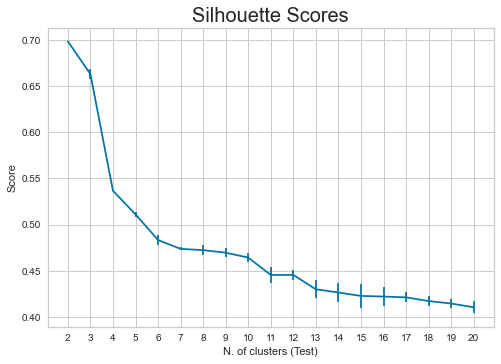

In [6]:
generate_silhoutte_score_plot(X_pca, 21, KMeans)

/opt/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


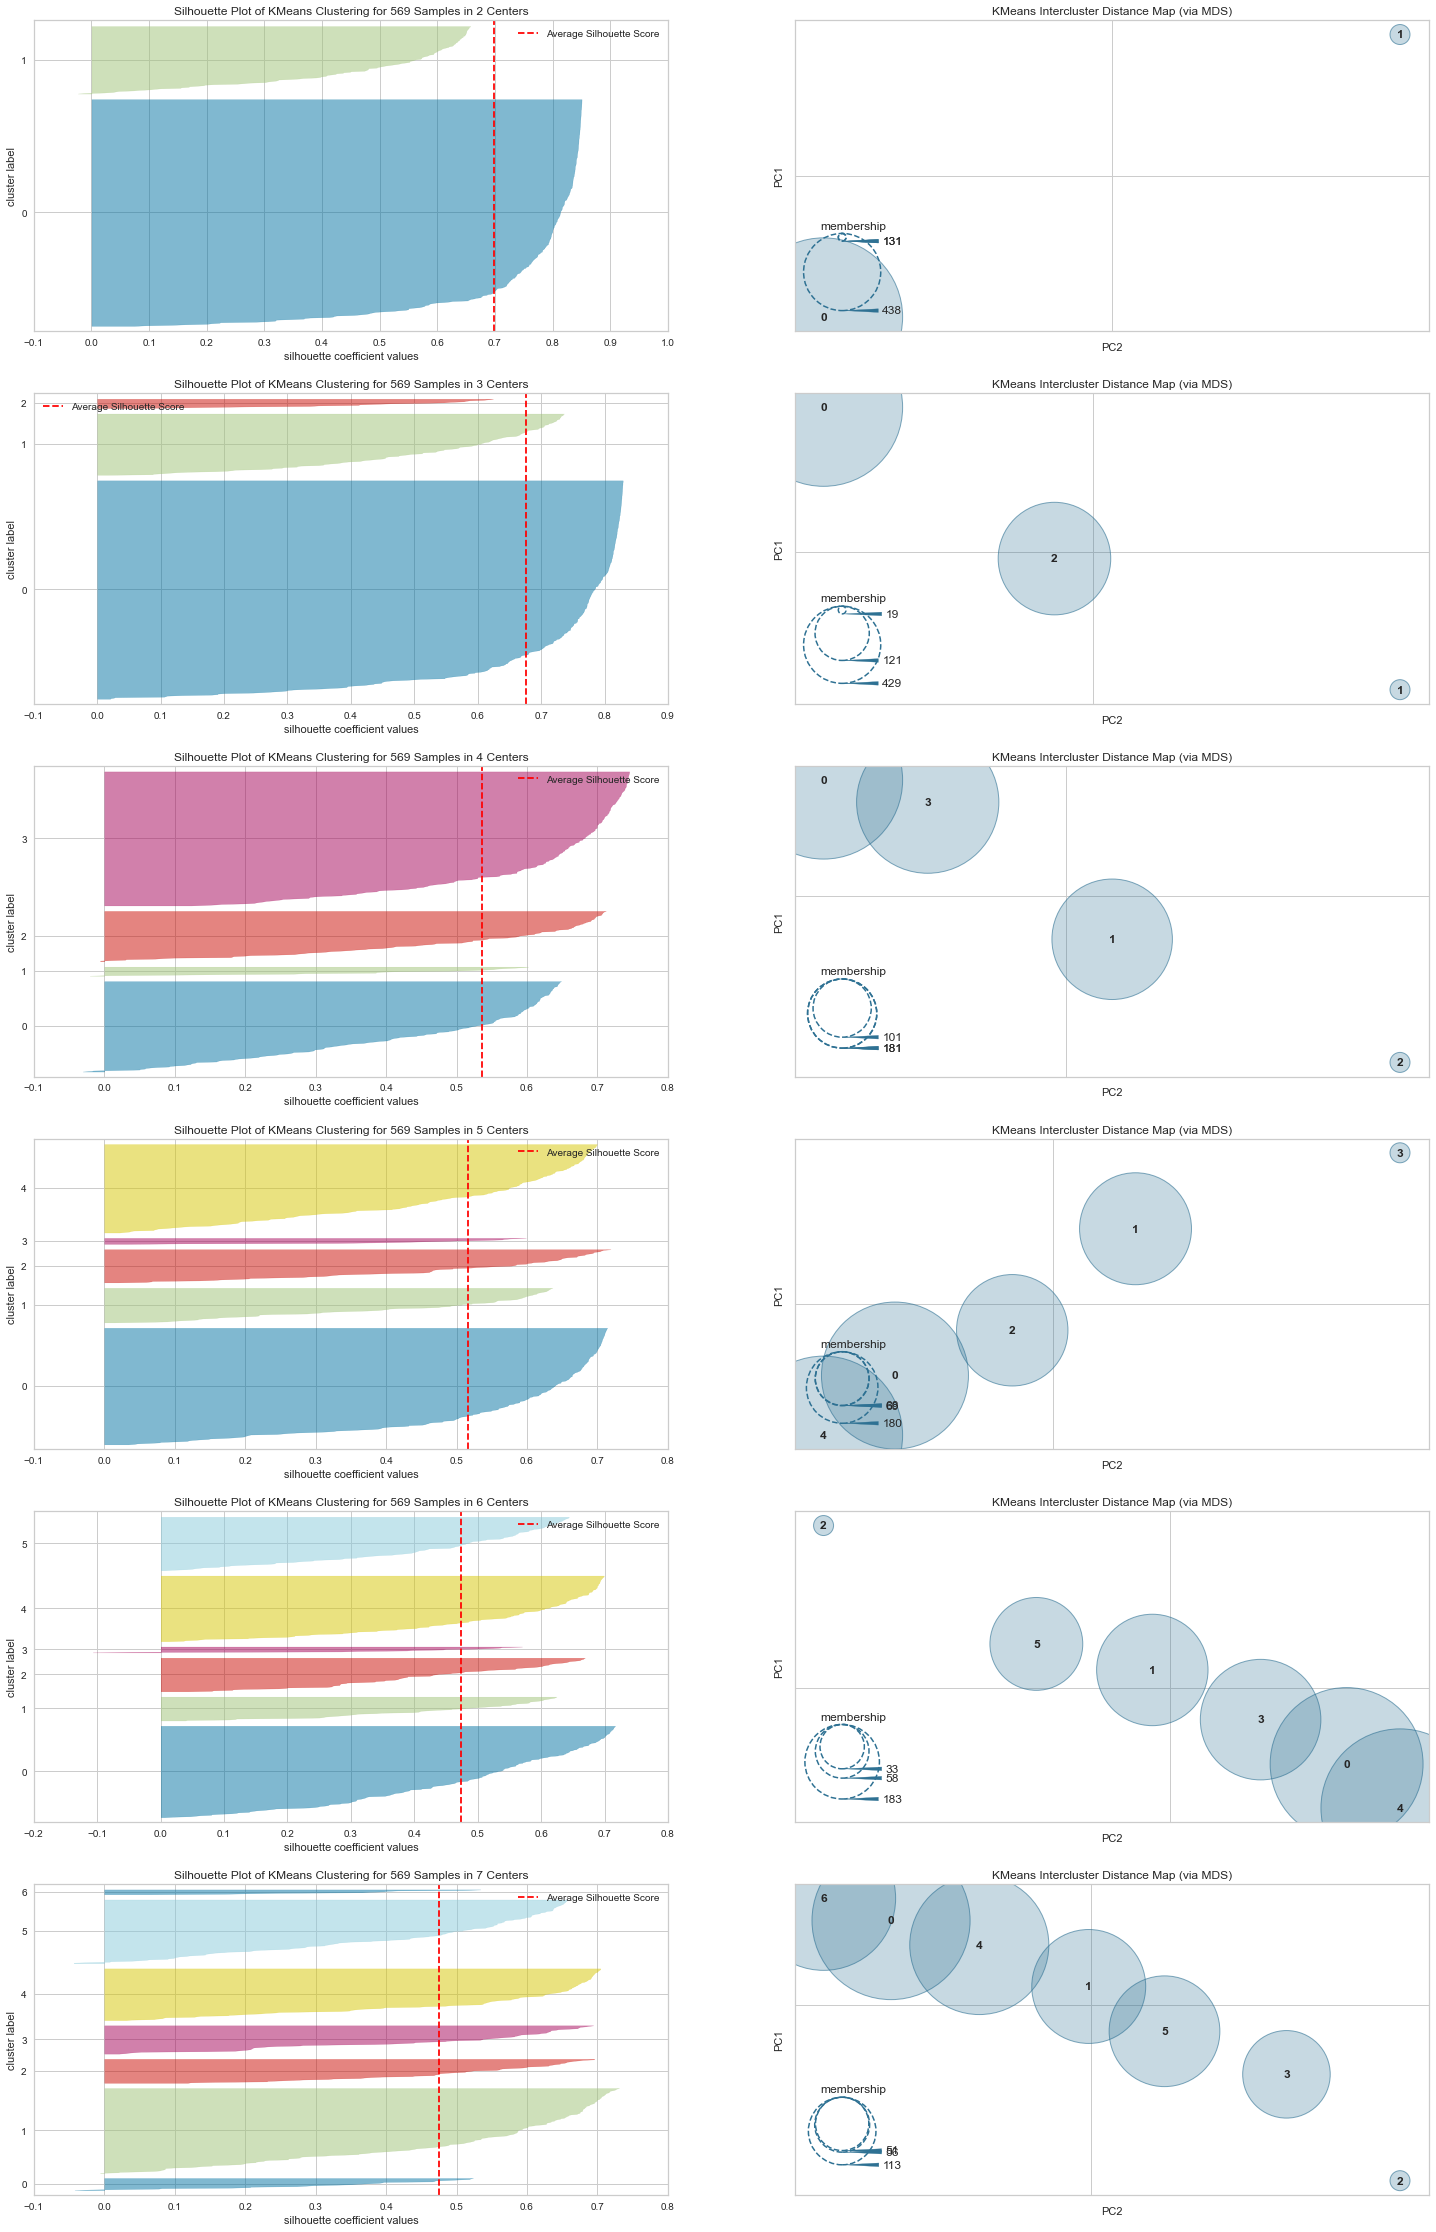

In [11]:
k = list(range(2,8))
generate_kmeans_SV_ICD_plots(X_pca, k)

## KMeans + ICA

In [14]:
X, y = load_data('wdbc-modified.data')
ica = FastICA(n_components= 5, max_iter=10000, tol=0.1).fit(X)
X_ica = ica.transform(X)

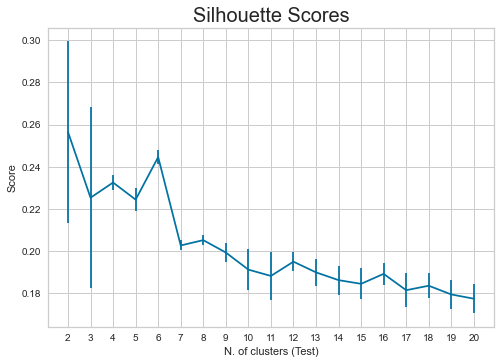

In [15]:
generate_silhoutte_score_plot(X_ica, 21, KMeans)

/opt/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


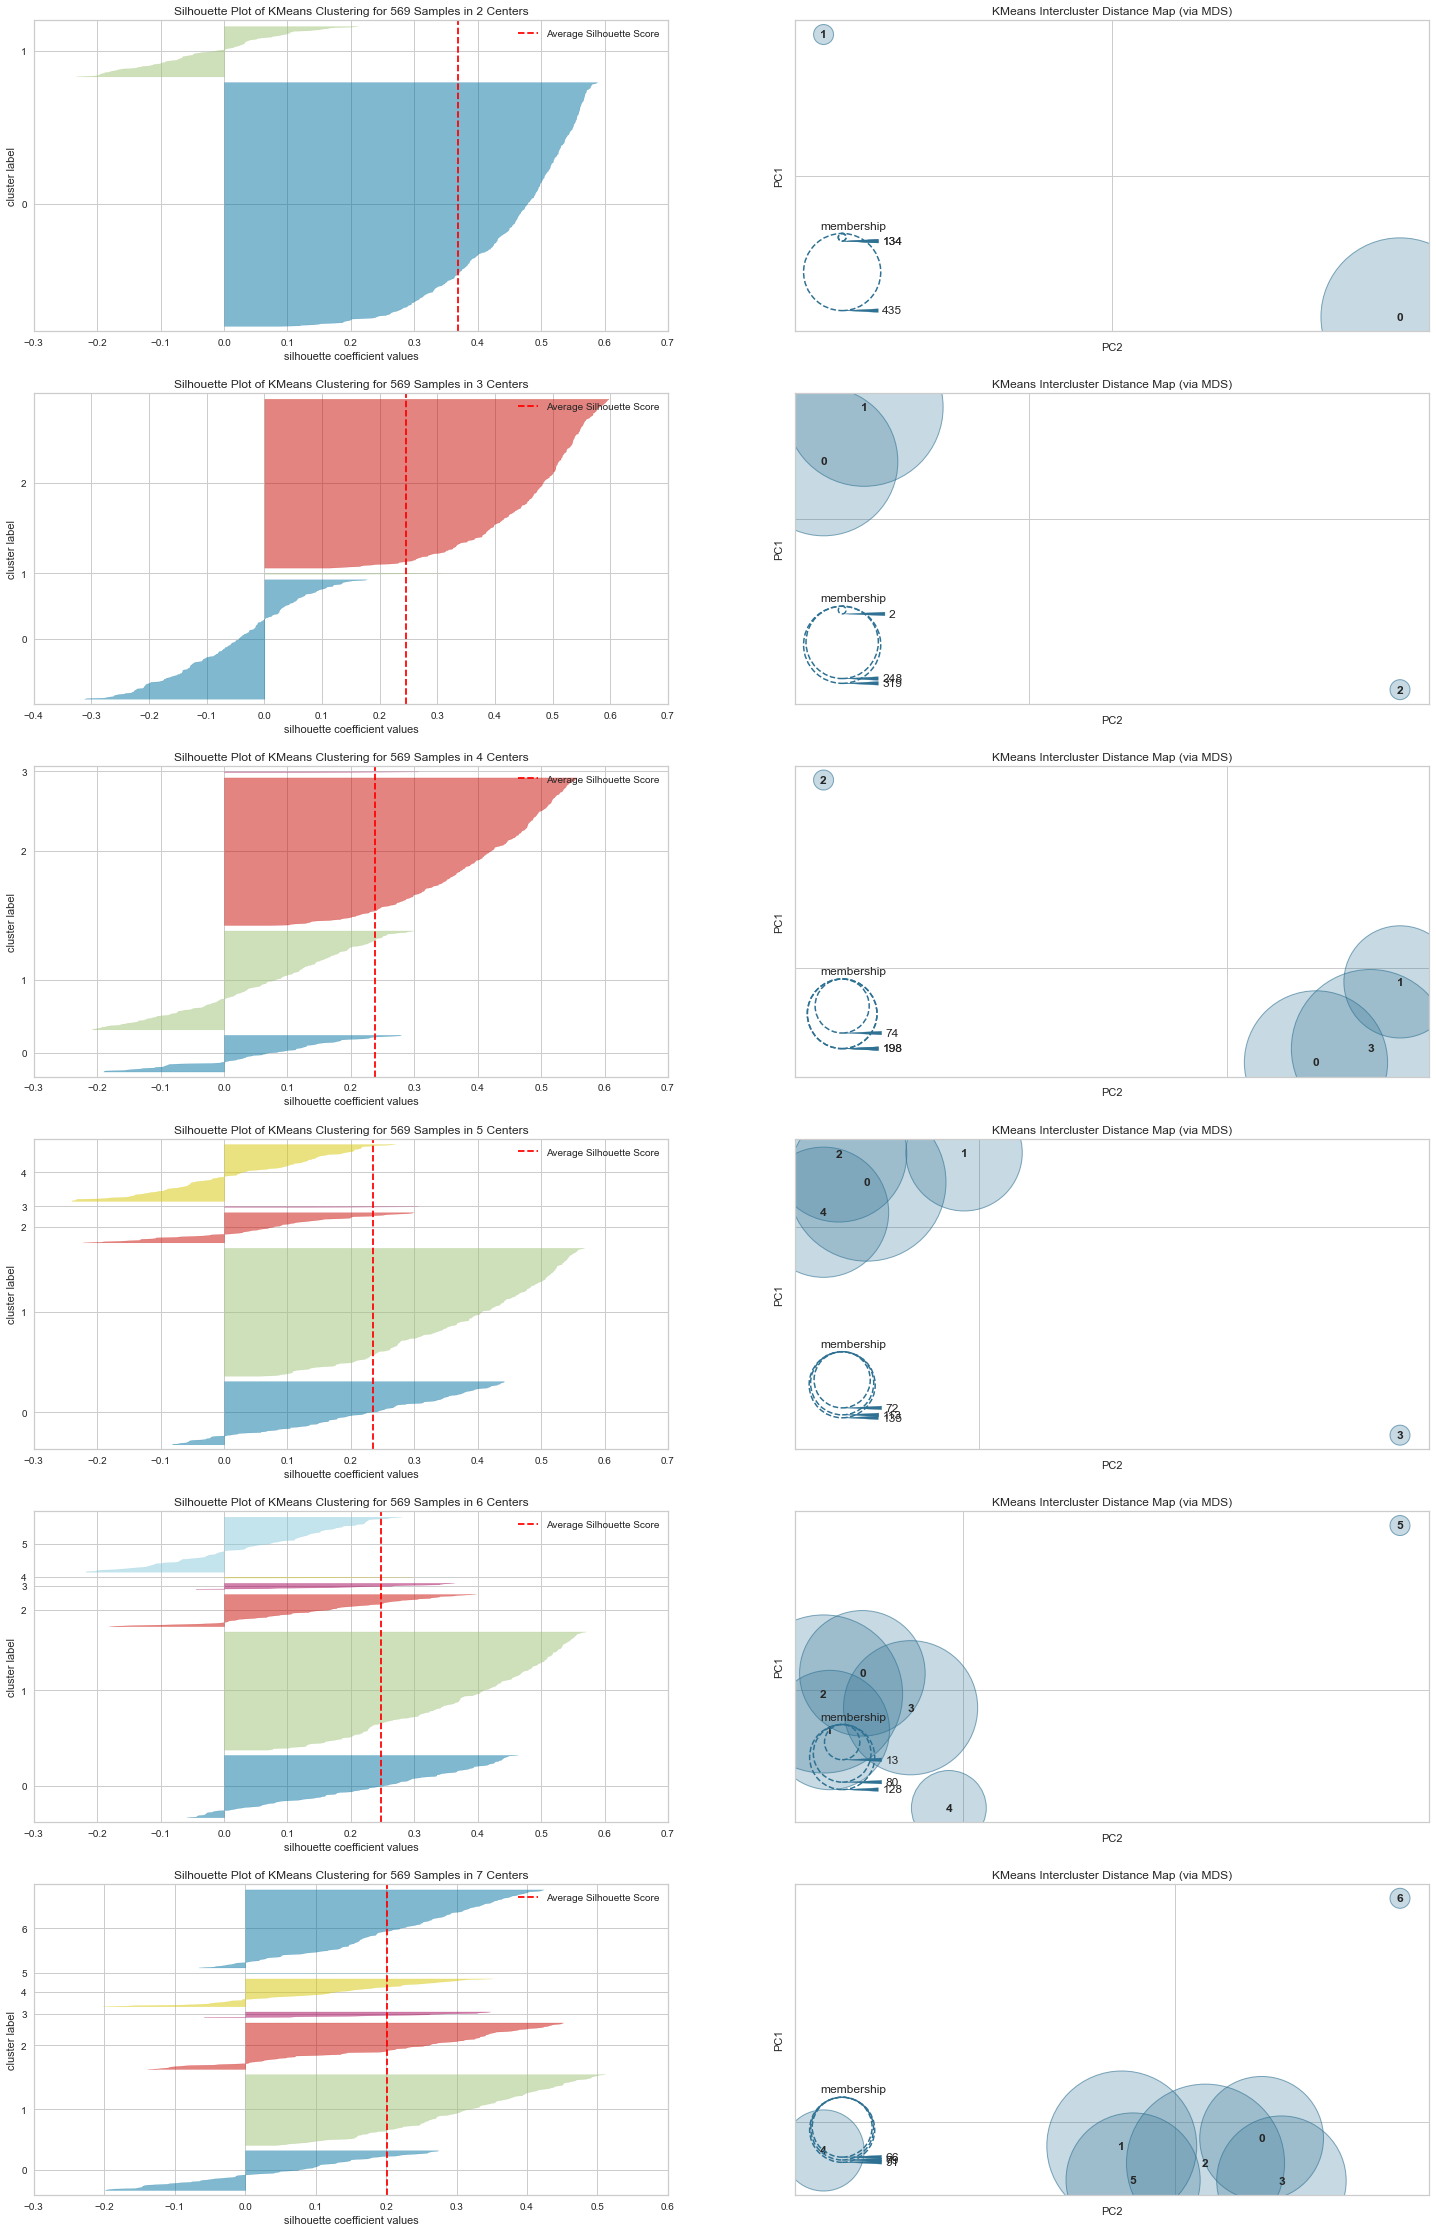

In [16]:
k = list(range(2,8))
generate_kmeans_SV_ICD_plots(X_ica, k)

## KMeans + Randomized Projections

In [22]:
X, y = load_data('wdbc-modified.data')
rp = random_projection.SparseRandomProjection(n_components=11)
X_rp=rp.fit_transform(X)

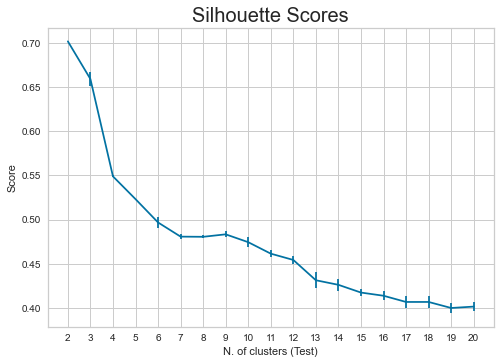

In [23]:
generate_silhoutte_score_plot(X_rp, 21, KMeans)

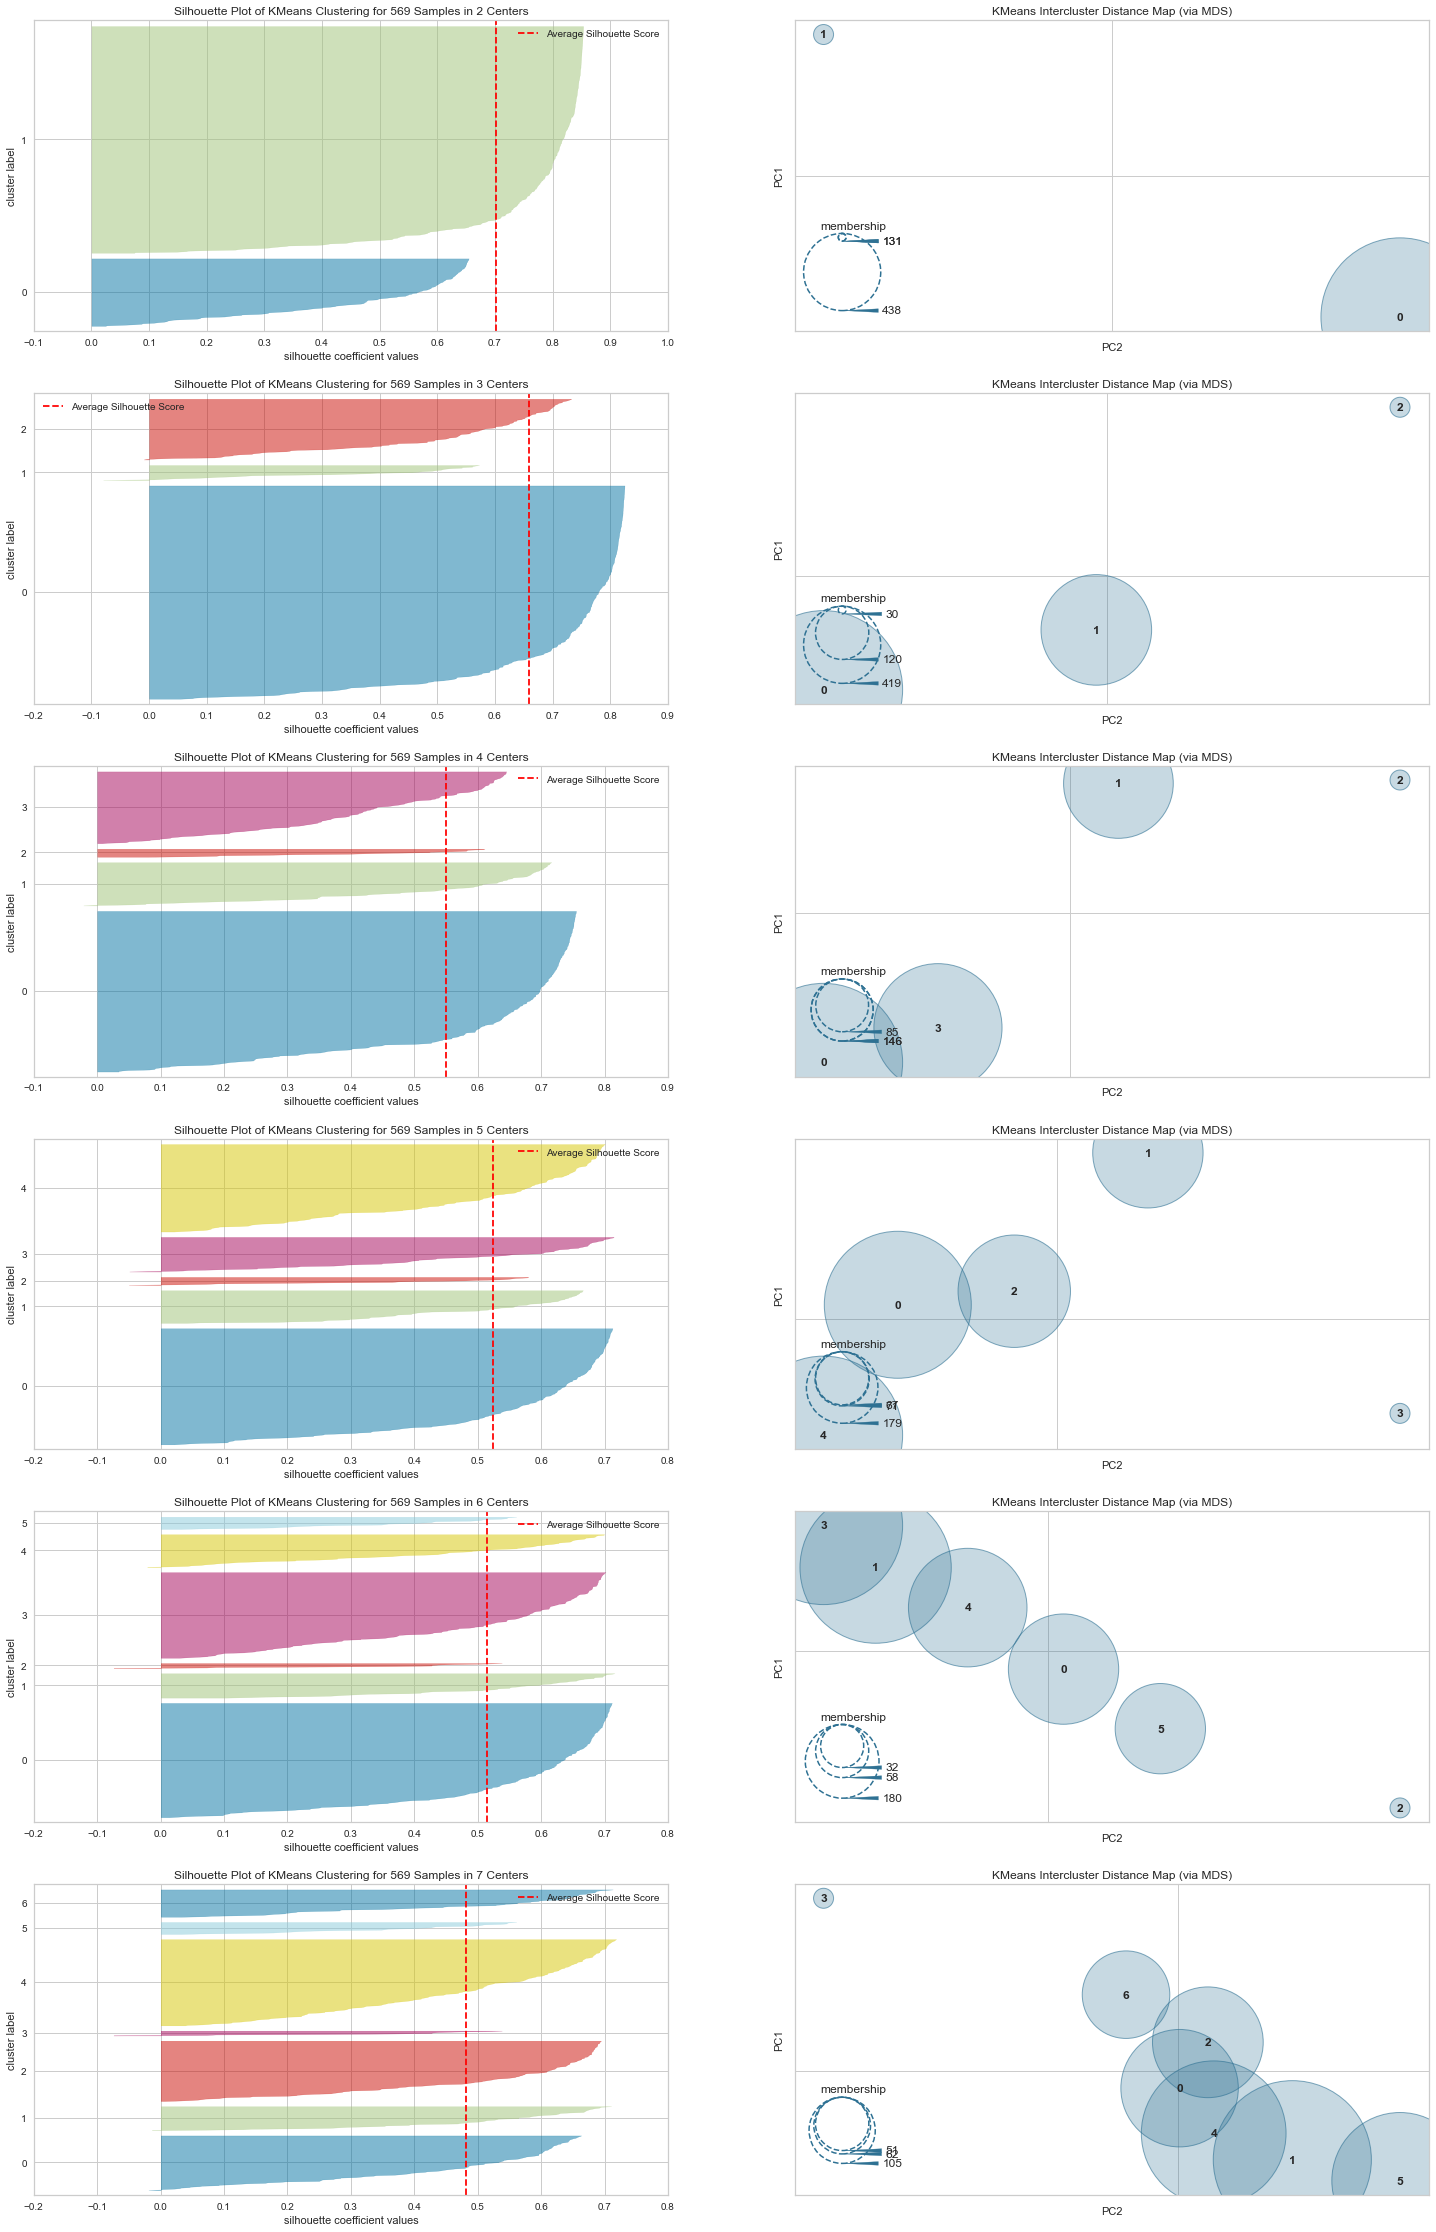

In [26]:
k = list(range(2,8))
generate_kmeans_SV_ICD_plots(X_rp, k)

## KMeans + SVD

In [33]:
X, y = load_data('wdbc-modified.data')
tsvd = TruncatedSVD(n_components=2)
X_tsvd = tsvd.fit_transform(X)

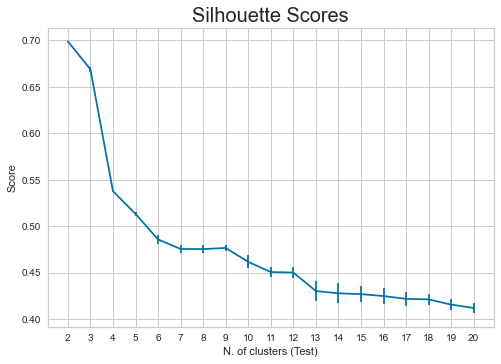

In [34]:
generate_silhoutte_score_plot(X_tsvd, 21, KMeans)

/opt/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


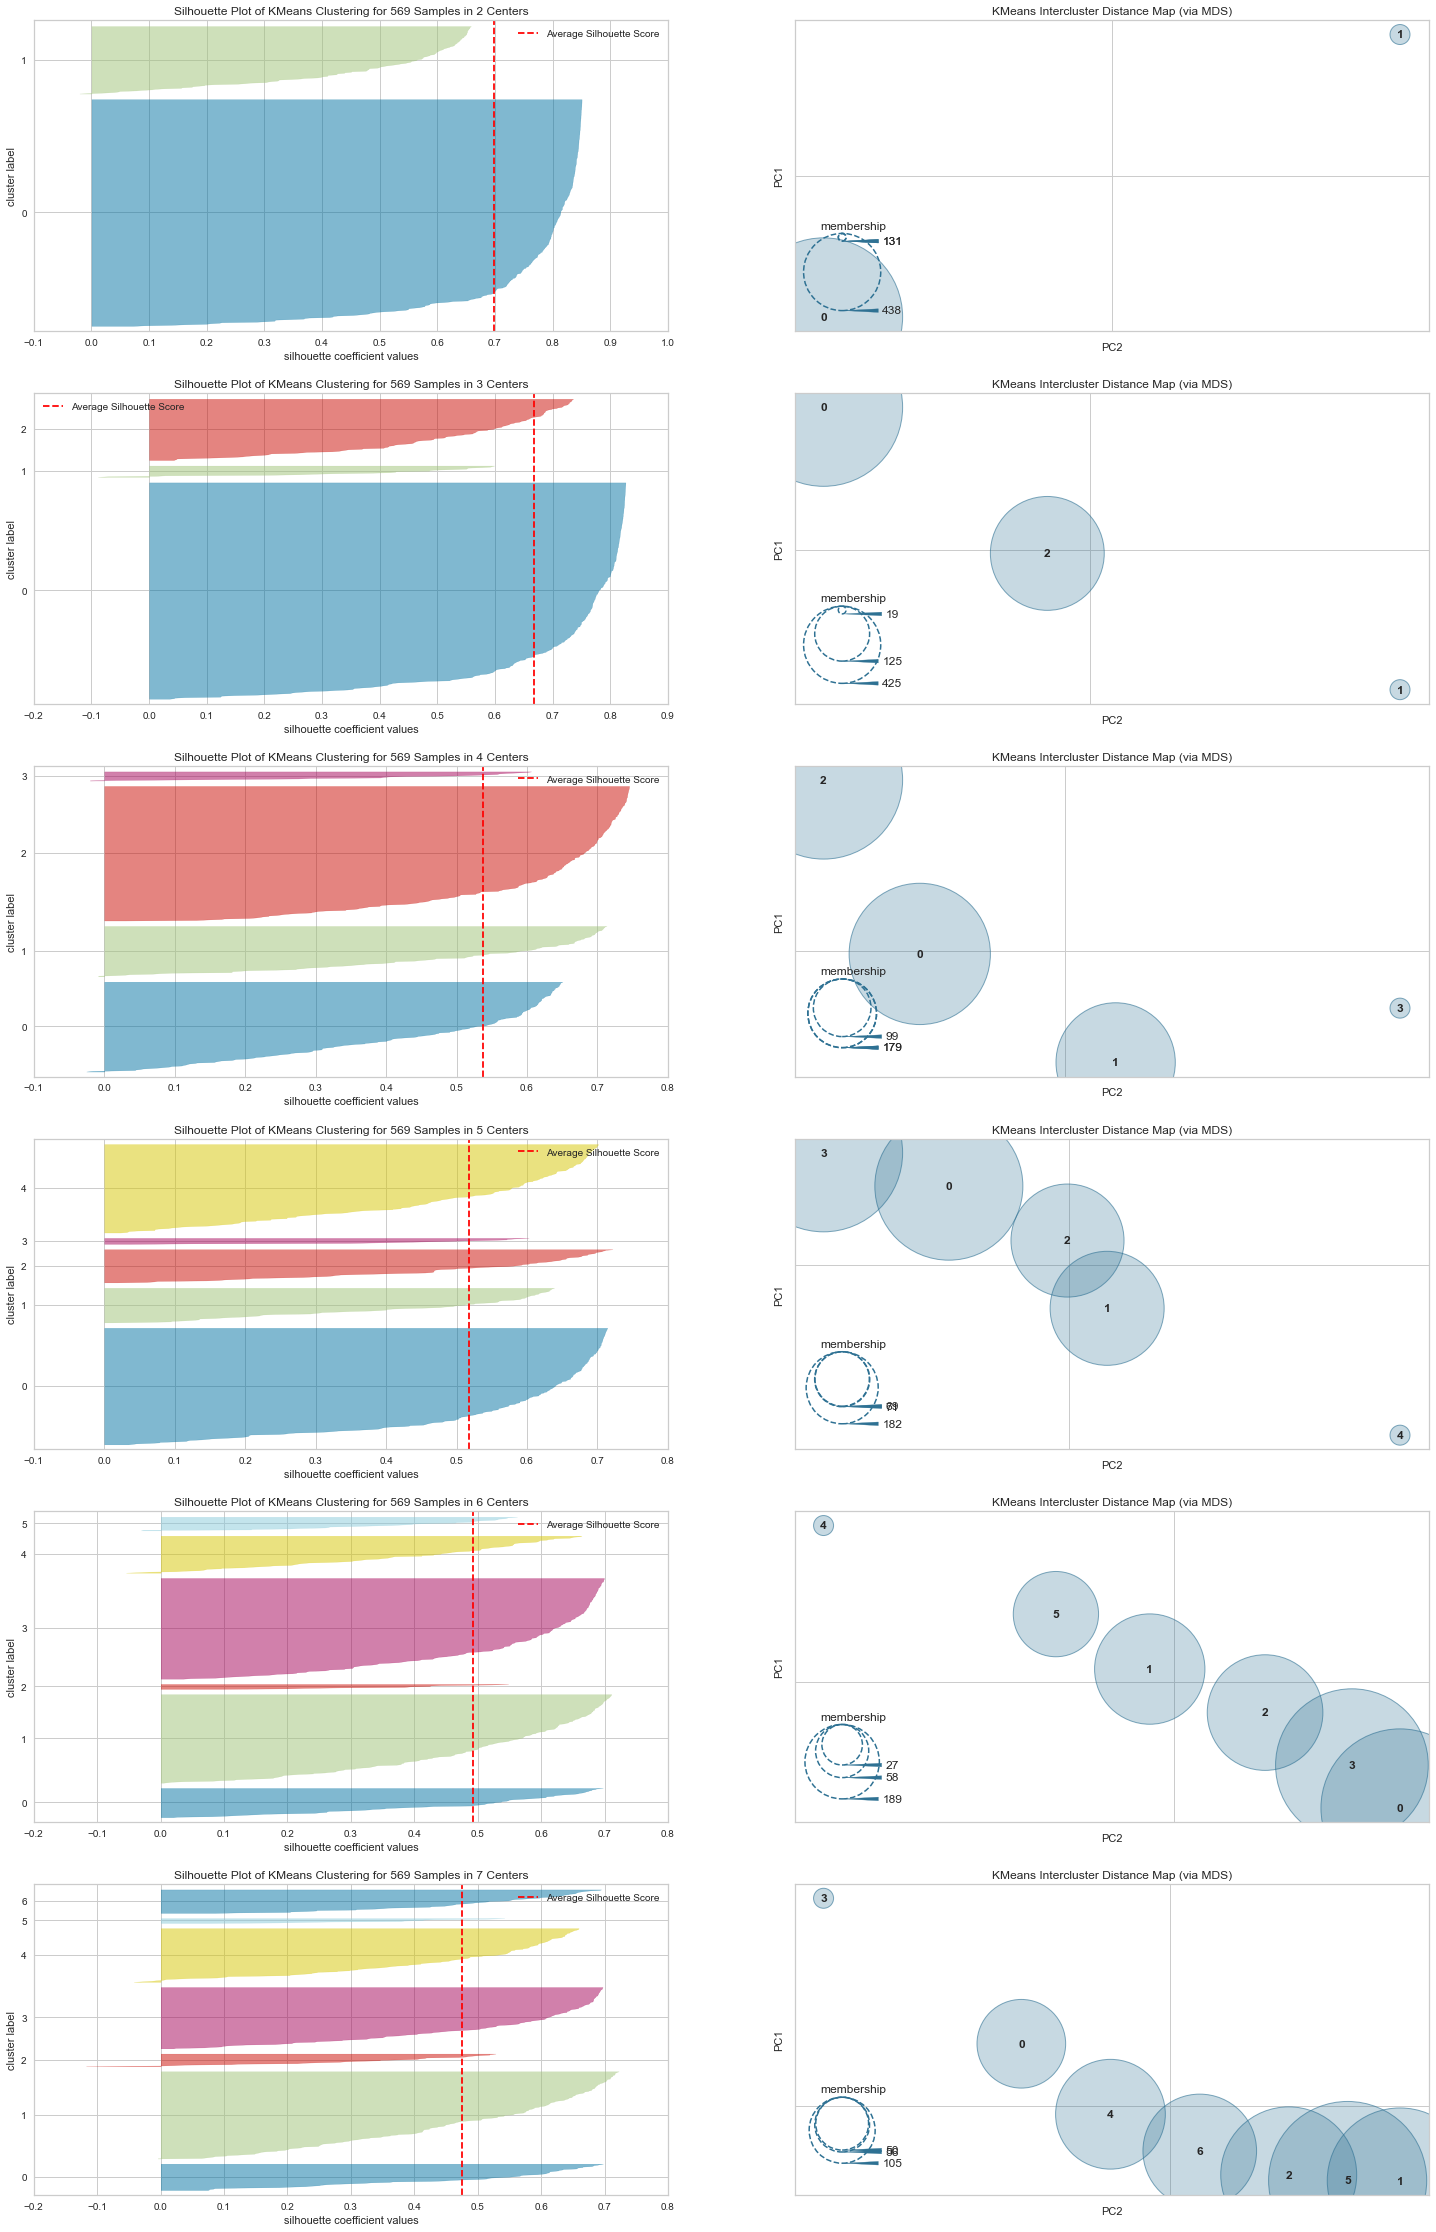

In [35]:
k = list(range(2,8))
generate_kmeans_SV_ICD_plots(X_pca, k)

## Expected Maximization + PCA

In [44]:
X, y = load_data('wdbc-modified.data')
pca = PCA(n_components= 2).fit(X)
X_pca = pca.transform(X)

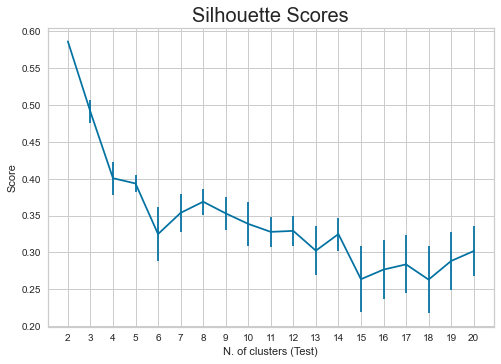

In [45]:
generate_silhoutte_score_plot(X_pca, 21, GaussianMixture)

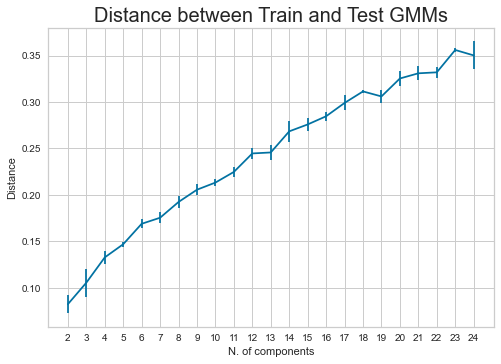

In [46]:
generate_distance_bw_gmms_plots(X_pca, 25)

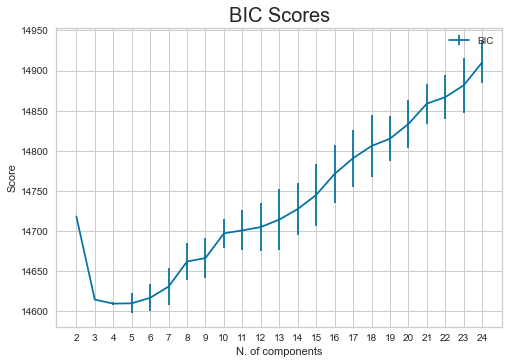

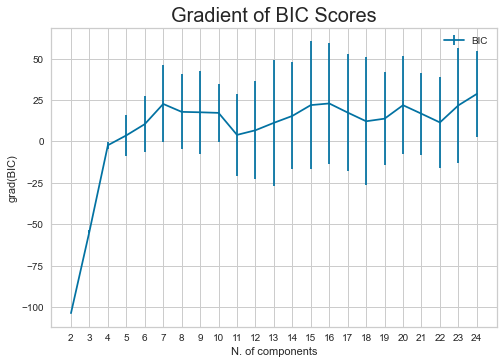

<Figure size 576x396 with 0 Axes>

In [47]:
generate_bic_plot(X_pca, 25)

## Expected Maximization + ICA

In [48]:
X, y = load_data('wdbc-modified.data')
ica = FastICA(n_components= 5, max_iter=10000, tol=0.1).fit(X)
X_ica = ica.transform(X)

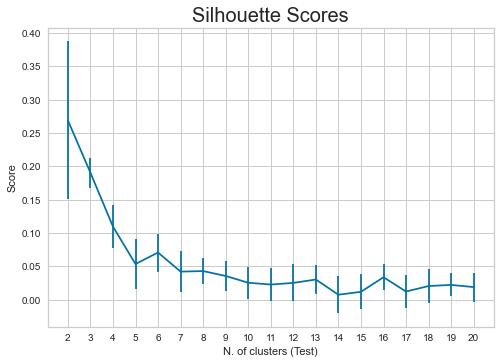

In [49]:
generate_silhoutte_score_plot(X_ica, 21, GaussianMixture)

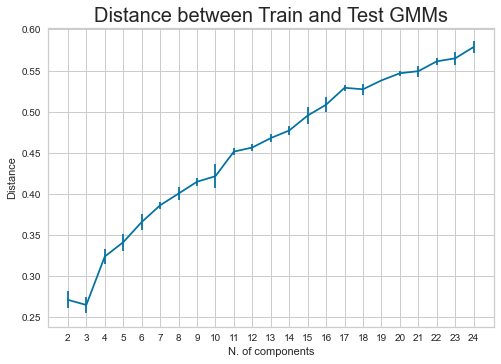

In [50]:
generate_distance_bw_gmms_plots(X_ica, 25)

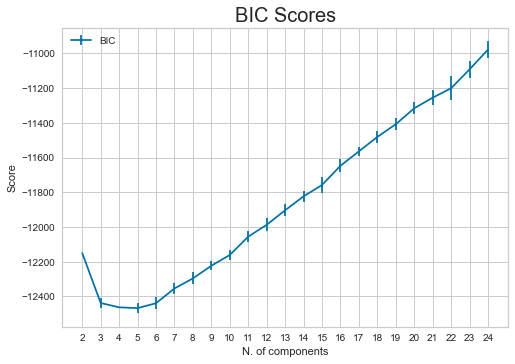

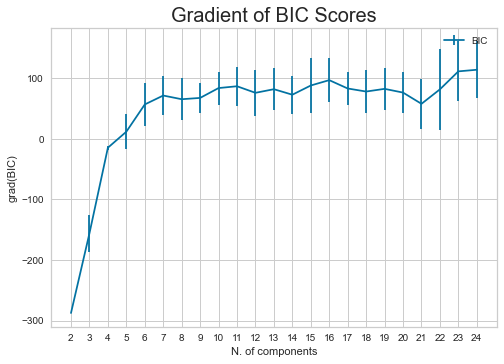

<Figure size 576x396 with 0 Axes>

In [51]:
generate_bic_plot(X_ica, 25)

## Expected Maximization + Randomized Projections

In [54]:
X, y = load_data('wdbc-modified.data')
rp = random_projection.SparseRandomProjection(n_components=11)
X_rp=rp.fit_transform(X)

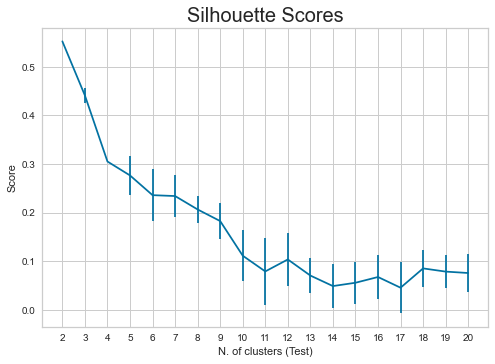

In [55]:
generate_silhoutte_score_plot(X_rp, 21, GaussianMixture)

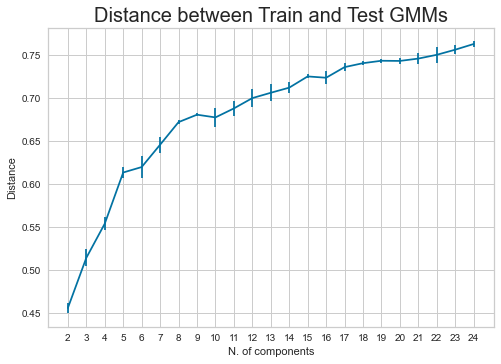

In [56]:
generate_distance_bw_gmms_plots(X_rp, 25)

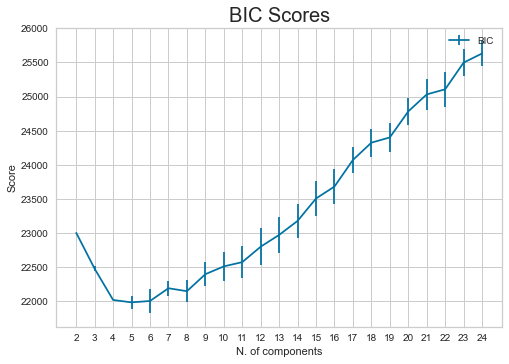

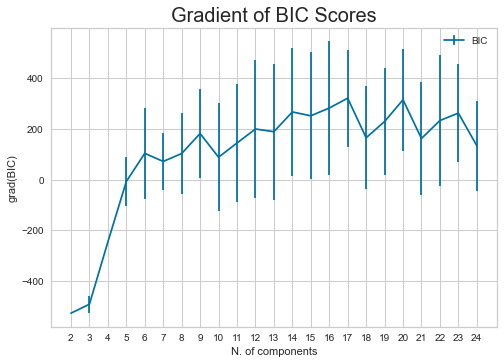

<Figure size 576x396 with 0 Axes>

In [57]:
generate_bic_plot(X_rp, 25)

## Expected Maximization + SVD

In [ ]:
X, y = load_data('wdbc-modified.data')
tsvd = TruncatedSVD(n_components=2)
X_tsvd = tsvd.fit_transform(X)

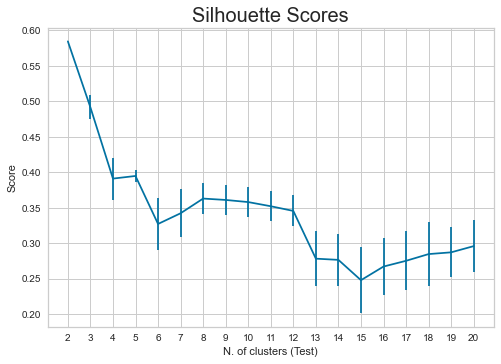

In [58]:
generate_silhoutte_score_plot(X_tsvd, 21, GaussianMixture)

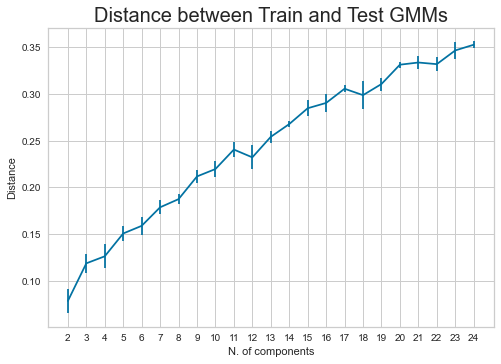

In [59]:
generate_distance_bw_gmms_plots(X_tsvd, 25)

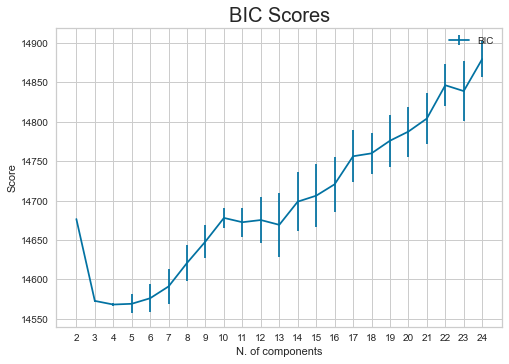

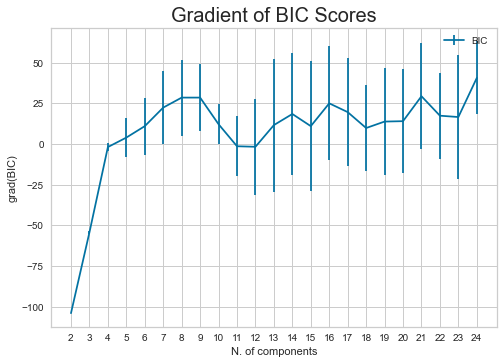

<Figure size 576x396 with 0 Axes>

In [61]:
generate_bic_plot(X_tsvd, 25)

# Train and Query Times

In [100]:
## Expected Maximization + PCA

In [101]:
X, y = load_data('wdbc-modified.data')
pca = PCA(n_components= 2).fit(X)
X_pca = pca.transform(X)

start = time.time()
gmm=GaussianMixture(8).fit(X_pca)
train_time = time.time() - start
print("Train time: " + str(train_time))

start = time.time()
gmm.predict(X_pca)
query_time = time.time() - start
print("Query time: " + str(query_time))

Train time: 0.03830409049987793
Query time: 0.0019440650939941406


In [102]:
## Expected Maximization + ICA

In [103]:
X, y = load_data('wdbc-modified.data')
ica = FastICA(n_components= 5, max_iter=10000, tol=0.1).fit(X)
X_ica = ica.transform(X)

start = time.time()
gmm=GaussianMixture(2).fit(X_ica)
train_time = time.time() - start
print("Train time: " + str(train_time))

start = time.time()
gmm.predict(X_ica)
query_time = time.time() - start
print("Query time: " + str(query_time))

Train time: 0.012953042984008789
Query time: 0.0008158683776855469


In [104]:
## Expected Maximization + RP

In [105]:
X, y = load_data('wdbc-modified.data')
rp = random_projection.SparseRandomProjection(n_components=8)
X_rp=rp.fit_transform(X)
start = time.time()
gmm=GaussianMixture(2).fit(X_rp)
train_time = time.time() - start
print("Train time: " + str(train_time))

start = time.time()
gmm.predict(X_rp)
query_time = time.time() - start
print("Query time: " + str(query_time))

Train time: 0.02300119400024414
Query time: 0.00040078163146972656


In [106]:
## Expected Maximization + SVD

In [107]:
X, y = load_data('wdbc-modified.data')
tsvd = TruncatedSVD(n_components=8)
X_tsvd = tsvd.fit_transform(X)
start = time.time()
gmm=GaussianMixture(2).fit(X_rp)
train_time = time.time() - start
print("Train time: " + str(train_time))

start = time.time()
gmm.predict(X_tsvd)
query_time = time.time() - start
print("Query time: " + str(query_time))

Train time: 0.020023107528686523
Query time: 0.0004031658172607422


In [108]:
## KMeans + PCA

In [109]:
X, y = load_data('wdbc-modified.data')
pca = PCA(n_components= 8).fit(X)
X_pca = pca.transform(X)

start = time.time()
gmm=KMeans(2).fit(X_pca)
train_time = time.time() - start
print("Train time: " + str(train_time))

start = time.time()
gmm.predict(X_pca)
query_time = time.time() - start
print("Query time: " + str(query_time))

Train time: 0.031900882720947266
Query time: 0.0006449222564697266


In [110]:
## KMeans + ICA

In [111]:
X, y = load_data('wdbc-modified.data')
ica = FastICA(n_components= 6, max_iter=10000, tol=0.1).fit(X)
X_ica = ica.transform(X)

start = time.time()
gmm=KMeans(2).fit(X_ica)
train_time = time.time() - start
print("Train time: " + str(train_time))

start = time.time()
gmm.predict(X_ica)
query_time = time.time() - start
print("Query time: " + str(query_time))

Train time: 0.07767891883850098
Query time: 0.0011639595031738281


In [112]:
## KMeans + RP

In [113]:
X, y = load_data('wdbc-modified.data')
rp = random_projection.SparseRandomProjection(n_components=8)
X_rp=rp.fit_transform(X)
start = time.time()
gmm=KMeans(2).fit(X_rp)
train_time = time.time() - start
print("Train time: " + str(train_time))

start = time.time()
gmm.predict(X_rp)
query_time = time.time() - start
print("Query time: " + str(query_time))

Train time: 0.03886103630065918
Query time: 0.0019450187683105469


In [114]:
## KMeans + SVD

In [115]:
X, y = load_data('wdbc-modified.data')
tsvd = TruncatedSVD(n_components=8)
X_tsvd = tsvd.fit_transform(X)
start = time.time()
gmm=KMeans(2).fit(X_tsvd)
train_time = time.time() - start
print("Train time: " + str(train_time))

start = time.time()
gmm.predict(X_tsvd)
query_time = time.time() - start
print("Query time: " + str(query_time))

Train time: 0.03414297103881836
Query time: 0.002586841583251953
